In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os 
from tqdm import tqdm 
from dataclasses import dataclass
from typing import Optional, List, Union, Dict, Any

In [28]:
def binarize_traces(df, threshold):
    """
    Return a copy of df where every value < threshold becomes 0,
    and every value >= threshold becomes 1.
    """
    return (df >= threshold).astype(int)

def suprathreshold_to_events(binary_series):
    b = np.asarray(binary_series).astype(int)
    # rising edges: 0->1 transitions
    events = (b == 1) & (np.r_[0, b[:-1]] == 0)
    return events.astype(int)

def get_event_rate(df, samplingRate):
    """
    Given a binarized DataFrame `df` of shape (n_frames, n_cells),
    compute, for each cell (column), the number of “events” in each
    forward-looking 1-second window. Returns a DataFrame of shape
    (n_frames - samplingRate + 1, n_cells).
    """
    # 1) grab the raw values (frames × cells)
    arr = df.values.astype(int)  
    # 2) build a “boxcar” kernel of length = samples per second
    kernel = np.ones(samplingRate, dtype=int)
    # 3) convolve along the time-axis for each cell (axis=0)
    #    mode='valid' gives you only positions where the full window fits
    rates = np.apply_along_axis(
        lambda col: np.convolve(col, kernel, mode='valid'),
        axis=0,
        arr=arr
    )
    # 4) build a new index so that row i corresponds to window df.index[i : i+samplingRate]
    #    if your original df.index is RangeIndex starting at 0, this is simply 0..n-sR
    new_index = df.index[: rates.shape[0]]
    return pd.DataFrame(rates, index=new_index, columns=df.columns)

def get_event_rate_same_length(df, samplingRate, pad_value=0):
    """
    Forward-looking 1-second (samplingRate-frame) window sums,
    same behavior as your mode='valid' version, but returns length == len(df)
    by padding the END with pad_value before convolution.
    """
    arr = df.to_numpy(dtype=int)
    kernel = np.ones(samplingRate, dtype=int)

    # pad the end so that 'valid' produces N outputs
    pad = samplingRate - 1
    arr_pad = np.pad(arr, ((0, pad), (0, 0)), mode='constant', constant_values=pad_value)

    rates = np.apply_along_axis(lambda col: np.convolve(col, kernel, mode='valid'), axis=0, arr=arr_pad)
    return pd.DataFrame(rates, index=df.index, columns=df.columns)

def get_indices_by_speed_bins(df, speed_col, bins):
    """
    For each (low, high) in `bins`, find the row-indices where
    low <= df[speed_col] < high (for high == inf, just low <=).
    
    Returns
    -------
    dict
        keys   : tuple (low, high)
        values : list of row-index labels in df
    """
    bin_indices = {}
    for low, high in bins:
        if np.isinf(high):
            mask = df[speed_col] >= low
        else:
            mask = (df[speed_col] >= low) & (df[speed_col] < high)
        bin_indices[(low, high)] = df.index[mask].tolist()
    return bin_indices

def avg_event_rate_by_speed_bins(df, idx_by_bin, speed_col='linearSpeedcmPerSecond'):
    """
    Given:
      • df            : DataFrame with one column per cell (instantaneous rates)
                        plus a `speed_col`.
      • idx_by_bin    : dict mapping (low, high) tuples → list of row-indices
                        where speed ∈ [low, high) (or >= low if high is inf).
      • speed_col     : name of the speed column in df (will be dropped).
    Returns:
      • avg_df        : DataFrame indexed by your (low, high) bins,
                        columns are the cell-names, entries are the mean
                        event-rate of that cell over all frames in that bin.
    """
    # 1) Identify all “cell” columns (everything except the speed column)
    event_cols = [c for c in df.columns if c != speed_col]

    # 2) Make a DataFrame to hold means; use a MultiIndex of your bin tuples
    bin_index = pd.MultiIndex.from_tuples(idx_by_bin.keys(), names=['low','high'])
    avg_df = pd.DataFrame(index=bin_index, columns=event_cols, dtype=float)

    # 3) For each bin, pull those rows and take the column‐wise mean
    for bin_range, idxs in idx_by_bin.items():
        if len(idxs)>0:
            avg_df.loc[bin_range] = df.loc[idxs, event_cols].mean()
        else:
            avg_df.loc[bin_range] = np.nan

    return avg_df


def apply_spatial_filter(
    df,
    frame_rate: int,
    square_box_threshold: float,
    coord_cols=('X_coor','Y_coor'),
    vel_col='velocity_PixelsPerSec'
):
    """
    Slide a window of `frame_rate` frames over the trajectory;
    whenever the animal stays within a ±square_box_threshold pixel
    box (around the start‐of‐window position) for the whole window,
    zero out the velocity over that window.

    Returns a new numpy array of filtered velocities.
    """
    X = df[coord_cols[0]].to_numpy()
    Y = df[coord_cols[1]].to_numpy()
    vel = df[vel_col].to_numpy().copy()
    n = len(df)
    w = frame_rate

    for i in range(n):
        end = min(i + w, n)
        cx, cy = X[i], Y[i]
        Xw, Yw = X[i:end], Y[i:end]

        # check if all points stay in the box
        if ((Xw >= cx - square_box_threshold) & (Xw <= cx + square_box_threshold)).all() \
        and ((Yw >= cy - square_box_threshold) & (Yw <= cy + square_box_threshold)).all():
            vel[i:end] = 0

    return vel

In [29]:
@dataclass
class PeakStats:
    peak_idx: int
    onset_idx: int
    offset_idx: int
    amp_max: float
    length_samples: int
    clip_start: int
    clip_end: int
    clipped_region: np.ndarray


def _as_1d_float_array(x: Union[pd.Series, np.ndarray, list], name: str) -> np.ndarray:
    arr = np.asarray(x)
    if arr.ndim != 1:
        raise ValueError(f"{name} must be 1D, got shape {arr.shape}")
    return arr.astype(float, copy=False)


def _as_1d_int_array(x: Union[pd.Series, np.ndarray, list], name: str) -> np.ndarray:
    arr = np.asarray(x)
    if arr.ndim != 1:
        raise ValueError(f"{name} must be 1D, got shape {arr.shape}")
    # treat truthy values as 1
    return (arr.astype(int, copy=False) != 0).astype(int)


def get_peak_stats_for_peak(
    peak_idx: int,
    *,
    tol: float,
    window_len_onset: int,
    window_len_offset: int,
    plt_region: int,
    z_scores: Union[pd.Series, np.ndarray, list],
    cell_trace: Union[pd.Series, np.ndarray, list],
) -> PeakStats:
    """
    Python translation of your MATLAB getPeakStatsFn for ONE peak index.

    Args:
        peak_idx: index of peak sample (0-based)
        tol: baseline tolerance for |z| < tol
        window_len_onset: consecutive samples within tol required for onset
        window_len_offset: consecutive samples within tol required for offset
        plt_region: # samples to include before onset and after offset for clipped_region
        z_scores: typically the z-scored trace (used for baseline detection)
        cell_trace: trace used for amplitude & baselineVal comparison (often same as z_scores)

    Returns:
        PeakStats
    """
    z = _as_1d_float_array(z_scores, "z_scores")
    tr = _as_1d_float_array(cell_trace, "cell_trace")

    N = len(z)
    if len(tr) != N:
        raise ValueError(f"z_scores and cell_trace must have same length, got {N} and {len(tr)}")
    if not (0 <= peak_idx < N):
        raise ValueError(f"peak_idx out of range: {peak_idx} for length {N}")
    if window_len_onset < 1 or window_len_offset < 1:
        raise ValueError("window_len_onset and window_len_offset must be >= 1")
    if plt_region < 0:
        raise ValueError("plt_region must be >= 0")

    # --- Find onset (search backward for first window of length window_len_onset all within tol) ---
    onset_idx = None
    # i is the END index of the window (inclusive), just like your MATLAB loop logic
    for i in range(peak_idx, window_len_onset - 2, -1):  # down to window_len_onset-1
        start = i - window_len_onset + 1
        if start < 0:
            break
        if np.all(np.abs(z[start:i + 1]) < tol):
            onset_idx = start
            break
    if onset_idx is None:
        onset_idx = 0

    # --- Find offset (search forward for first window of length window_len_offset within tol AND below baselineVal) ---
    baseline_val = tr[onset_idx]
    offset_idx = None
    last_start = N - window_len_offset
    for i in range(peak_idx, last_start + 1):
        w = slice(i, i + window_len_offset)
        if np.all(np.abs(z[w]) < tol) and np.all(tr[w] < baseline_val):
            offset_idx = i + window_len_offset - 1
            break
    if offset_idx is None:
        offset_idx = N - 1

    # --- amp max and length ---
    amp_max = float(np.max(tr[onset_idx:offset_idx + 1]))
    length_samples = int(offset_idx - onset_idx)

    # --- clipped region for plotting ---
    clip_start = max(0, onset_idx - plt_region)
    clip_end = min(N - 1, offset_idx + plt_region)
    clipped_region = tr[clip_start:clip_end + 1].copy()

    return PeakStats(
        peak_idx=int(peak_idx),
        onset_idx=int(onset_idx),
        offset_idx=int(offset_idx),
        amp_max=amp_max,
        length_samples=length_samples,
        clip_start=int(clip_start),
        clip_end=int(clip_end),
        clipped_region=clipped_region,
    )


def find_peak_indices_from_binarized(
    peaks_binary: Union[pd.Series, np.ndarray, list],
    *,
    z_scores: Optional[Union[pd.Series, np.ndarray, list]] = None,
) -> np.ndarray:
    """
    Given a binarized trace (0/1), return a single peak_idx per event by:
      - grouping contiguous 1's into events
      - choosing the index of max z within each event if z_scores provided
      - otherwise choosing the center index of each event
    """
    b = _as_1d_int_array(peaks_binary, "peaks_binary")
    idx1 = np.flatnonzero(b == 1)
    if idx1.size == 0:
        return np.array([], dtype=int)

    # split into contiguous groups
    breaks = np.where(np.diff(idx1) > 1)[0]
    starts = np.r_[0, breaks + 1]
    ends = np.r_[breaks, idx1.size - 1]

    if z_scores is not None:
        z = _as_1d_float_array(z_scores, "z_scores")
        peak_idxs = []
        for s, e in zip(starts, ends):
            event_idx = idx1[s:e + 1]
            # peak is argmax z within event
            peak_idxs.append(int(event_idx[np.argmax(z[event_idx])]))
        return np.array(peak_idxs, dtype=int)

    # fallback: center of event
    peak_idxs = []
    for s, e in zip(starts, ends):
        event_idx = idx1[s:e + 1]
        peak_idxs.append(int(event_idx[len(event_idx) // 2]))
    return np.array(peak_idxs, dtype=int)


def compute_peak_stats_from_cell(
    peaks_binary: Union[pd.Series, np.ndarray, list],
    *,
    z_scores: Union[pd.Series, np.ndarray, list],
    cell_trace: Optional[Union[pd.Series, np.ndarray, list]] = None,
    tol: float = 0.25,
    window_len_onset: int = 3,
    window_len_offset: int = 3,
    plt_region: int = 10,
) -> pd.DataFrame:
    """
    End-to-end:
      - takes one binarized cell column (peaks_binary)
      - takes z_scores (usually the z-scored calcium trace)
      - finds per-event peak indices
      - computes onset/offset/amp/length/clipping for each peak

    Returns:
      DataFrame with one row per detected event.
      Note: `clipped_region` is stored as a numpy array object in the DataFrame.
    """
    z = _as_1d_float_array(z_scores, "z_scores")
    tr = _as_1d_float_array(cell_trace if cell_trace is not None else z_scores, "cell_trace")

    peak_idxs = find_peak_indices_from_binarized(peaks_binary, z_scores=z)

    rows: List[Dict[str, Any]] = []
    for pidx in peak_idxs:
        stats = get_peak_stats_for_peak(
            pidx,
            tol=tol,
            window_len_onset=window_len_onset,
            window_len_offset=window_len_offset,
            plt_region=plt_region,
            z_scores=z,
            cell_trace=tr,
        )
        rows.append({
            "peak_idx": stats.peak_idx,
            "onset_idx": stats.onset_idx,
            "offset_idx": stats.offset_idx,
            "amp_max": stats.amp_max,
            "length_samples": stats.length_samples,
            "clip_start": stats.clip_start,
            "clip_end": stats.clip_end,
            "clipped_region": stats.clipped_region,  # object column (array)
        })

    return pd.DataFrame(rows)


In [73]:
def compute_peak_stats_for_all_cells(
    signalPeaks: pd.DataFrame,
    aligned_cell_traces: pd.DataFrame,
    *,
    cell_prefix: str = "cell_",
    tol: float = 0.25,
    window_len_onset: int = 3,
    window_len_offset: int = 3,
    plt_region: int = 10,
    use_onsets: bool = False,
) -> pd.DataFrame:
    """
    Loop over all cells, compute peak stats per detected event, and return one
    long (tidy) DataFrame with a 'cell' column and one row per event.

    Parameters
    ----------
    signalPeaks : DataFrame
        Binarized (0/1) traces per cell (columns like cell_0, cell_1, ...).
    aligned_cell_traces : DataFrame
        Z-scored (or amplitude) traces per cell, same columns and length.
    use_onsets : bool
        If True, convert suprathreshold runs into rising-edge events before stats.

    Returns
    -------
    stats_all : DataFrame
        Columns: cell, event_id, peak_idx, onset_idx, offset_idx, amp_max,
                 length_samples, clip_start, clip_end, clipped_region
    """
    # choose which binary to use for peak detection
    if use_onsets:
        peaks_binary_df = signalPeaks.apply(suprathreshold_to_events, axis=0)
    else:
        peaks_binary_df = signalPeaks

    # decide which cells to process
    cell_cols = [c for c in signalPeaks.columns if c.startswith(cell_prefix)]
    cell_cols = [c for c in cell_cols if c in aligned_cell_traces.columns]

    rows = []
    for cell_name in cell_cols:
        stats_df = compute_peak_stats_from_cell(
            peaks_binary_df[cell_name],
            z_scores=aligned_cell_traces[cell_name],
            cell_trace=aligned_cell_traces[cell_name],
            tol=tol,
            window_len_onset=window_len_onset,
            window_len_offset=window_len_offset,
            plt_region=plt_region,
        )
        if stats_df.empty:
            continue

        stats_df = stats_df.copy()
        stats_df.insert(0, "cell", cell_name)
        stats_df.insert(1, "event_id", np.arange(len(stats_df), dtype=int))
        rows.append(stats_df)

    if not rows:
        return pd.DataFrame(
            columns=[
                "cell","event_id","peak_idx","onset_idx","offset_idx","amp_max",
                "length_samples","clip_start","clip_end","clipped_region"
            ]
        )

    return pd.concat(rows, ignore_index=True)

def append_binned_event_frames(
    stats_all: pd.DataFrame,
    alignedTraces: pd.DataFrame,
    *,
    frame_col: str = "closestBehavCamFrameIdx",
    add_bin_rowpos: bool = True,
) -> pd.DataFrame:
    """
    Adds columns mapping onset/peak/offset indices (alignedTraces rows)
    -> corresponding behavior frame bins (closestBehavCamFrameIdx).
    """
    out = stats_all.copy()

    # This assumes stats_all onset_idx/peak_idx/offset_idx refer to row positions in alignedTraces.
    # If alignedTraces has a RangeIndex, .iloc is correct and fastest.
    behav_frames = alignedTraces[frame_col].to_numpy()

    for src, dst in [
        ("onset_idx",  "onset_behavFrame"),
        ("peak_idx",   "peak_behavFrame"),
        ("offset_idx", "offset_behavFrame"),
    ]:
        idx = out[src].to_numpy(dtype=int)
        out[dst] = behav_frames[idx]

    if add_bin_rowpos:
        # binned typically has index == closestBehavCamFrameIdx (can be non-contiguous)
        # rowpos is a dense 0..nBins-1 position after sorting unique frame ids
        unique_sorted = np.array(sorted(pd.unique(alignedTraces[frame_col].dropna().astype(int))))
        pos_map = pd.Series(np.arange(len(unique_sorted), dtype=int), index=unique_sorted)

        out["onset_bin_row"]  = pos_map.reindex(out["onset_behavFrame"].astype(int)).to_numpy()
        out["peak_bin_row"]   = pos_map.reindex(out["peak_behavFrame"].astype(int)).to_numpy()
        out["offset_bin_row"] = pos_map.reindex(out["offset_behavFrame"].astype(int)).to_numpy()

    return out

In [67]:
def avg_rate_by_spatial_bins(df, n_bins=32, x_col="X_coor", cell_prefix="cell_"):
    # cell columns = everything that starts with "cell_"
    cell_cols = [c for c in df.columns if c.startswith(cell_prefix)]

    # equal-width bins across observed X range
    edges = np.linspace(df[x_col].min(), df[x_col].max(), n_bins + 1)
    xbin = pd.cut(df[x_col], bins=edges, include_lowest=True, labels=False)

    # mean rate per bin per cell + occupancy
    out = df[cell_cols].groupby(xbin).mean()
    out.index.name = "x_bin"
    out["n_samples"] = xbin.value_counts().sort_index().to_numpy()
    out["x_left"] = edges[:-1]
    out["x_right"] = edges[1:]
    out["x_center"] = (edges[:-1] + edges[1:]) / 2
    return out

def normalize_peak_to_one(df, cell_prefix="cell_"):
    out = df.copy()
    cell_cols = [c for c in out.columns if c.startswith(cell_prefix)]
    peak = out[cell_cols].max(axis=0)                 # max per cell across bins
    peak = peak.replace(0, np.nan)                    # avoid divide-by-zero
    out[cell_cols] = out[cell_cols].div(peak, axis=1) # each cell scaled so max==1
    return out

def plot_spatial_rate_heatmap(
    df,
    cells=None,                  # None = all cells; or list like ["cell_0","cell_12",...]
    cell_prefix="cell_",
    sort_by_peak_bin=False,      # optionally sort rows by each cell's peak bin
    use_x_centers=True,          # label x-axis with x_center if present
    title="Spatial firing rate heatmap",
    figsize=(10, 8),
    aspect="auto",
    label_all_cells=True,        # NEW: annotate every row with its cell name
    alternate_sides=True,        # NEW: alternate left/right for readability
    label_fontsize=7,            # NEW: control label size
    label_pad=0.6,               # NEW: how far outside image to place labels (in data units)
):
    # pick cell columns
    all_cell_cols = [c for c in df.columns if c.startswith(cell_prefix)]
    if cells is None:
        cell_cols = all_cell_cols
    else:
        cell_cols = [c for c in cells if c in df.columns]
        if len(cell_cols) == 0:
            raise ValueError("None of the requested cells were found in df columns.")

    # matrix: bins x cells -> transpose to cells x bins
    mat = df[cell_cols].to_numpy().T  # (n_cells, n_bins)

    # optional sorting by peak location
    if sort_by_peak_bin and mat.shape[0] > 0:
        peak_bins = np.nanargmax(np.nan_to_num(mat, nan=-np.inf), axis=1)
        order = np.argsort(peak_bins)
        mat = mat[order, :]
        cell_cols = [cell_cols[i] for i in order]

    # x-axis labels
    if use_x_centers and ("x_center" in df.columns):
        x = df["x_center"].to_numpy()
        x_label = "X position (bin center)"
    else:
        x = np.arange(mat.shape[1])
        x_label = "Spatial bin"

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(mat, interpolation="nearest", aspect=aspect)
    fig.colorbar(im, ax=ax, label="Firing rate (raw or normalized)")
    ax.set_xlabel(x_label)
    ax.set_ylabel("Cell")
    ax.set_title(title)

    # x ticks: show ~10
    n_bins = mat.shape[1]
    if n_bins > 1:
        xt = np.linspace(0, n_bins - 1, min(10, n_bins)).astype(int)
        ax.set_xticks(xt)
        ax.set_xticklabels(
            [f"{x[i]:.1f}" if use_x_centers and ("x_center" in df.columns) else str(i) for i in xt],
            rotation=45, ha="right"
        )

    n_cells = mat.shape[0]

    if label_all_cells:
        # turn off y ticks so they don't fight with annotations
        ax.set_yticks([])

        # expand x-limits so text drawn "outside" is visible
        left_x = -0.5 - label_pad
        right_x = (n_bins - 1) + 0.5 + label_pad
        ax.set_xlim(left_x, right_x)

        for r, name in enumerate(cell_cols):
            if alternate_sides:
                if (r % 2) == 0:
                    # left
                    ax.text(-0.5 - label_pad, r, name, va="center", ha="right", fontsize=label_fontsize)
                else:
                    # right
                    ax.text((n_bins - 1) + 0.5 + label_pad, r, name, va="center", ha="left", fontsize=label_fontsize)
            else:
                # all on left
                ax.text(-0.5 - label_pad, r, name, va="center", ha="right", fontsize=label_fontsize)

    else:
        # fallback: normal ticks (may get crowded)
        ax.set_yticks(np.arange(n_cells))
        ax.set_yticklabels(cell_cols)

    plt.tight_layout()
    plt.show()



In [30]:

#path to eZTrack data
dirPath = '/Users/johnmarshall/Documents/Analysis/miniscope_analysis/miniscopeLinearTrack/firingRateAnalysis/07_2025_m388/'

alignedFile = '388_run4_20250702_motion_correctedcellTracesAlignedToTracking.csv'

#load calcium signal aligned to tracking data 
alignedTraces = pd.read_csv(dirPath+alignedFile)
#separate out location data 
alignedTracesLocationData = alignedTraces[['closestBehavCamFrameIdx', 'X_coor', 'Y_coor']]
#separate out cell traces
aligned_cell_traces = alignedTraces.loc[:, alignedTraces.columns.str.startswith('cell_')]
#threshold signal 
firingThresholdSD = 2.5
signalPeaks = binarize_traces(aligned_cell_traces, firingThresholdSD)
signalPeaksOnsets = signalPeaks.apply(suprathreshold_to_events, axis=0)

samplingRate = 20 

instantaneousEventRate = get_event_rate_same_length(signalPeaks, samplingRate=20)
instantaneousEventRateOnsets = get_event_rate_same_length(signalPeaksOnsets, samplingRate=20)

#this calculates the velocity in pixels per second from both the x and y coordinates 
alignedTraces['velocity_PixelsPerSec'] = (np.hypot(
    alignedTraces['X_coor'].diff(),
    alignedTraces['Y_coor'].diff()
    ) * samplingRate
).fillna(0)

#take just the X coordinate column and calculate a X velocity (in pixels)
samplingRate = 20 
linearSpeed = abs(alignedTraces['X_coor'].diff() * samplingRate)
linearSpeed.fillna(0, inplace=True)
pixelsPercm = 3.8
linearSpeedcmPerSecond = linearSpeed / pixelsPercm

#append to event rate dataframe 
instantaneousEventRate['linearSpeedcmPerSecond'] = linearSpeedcmPerSecond
instantaneousEventRateOnsets['linearSpeedcmPerSecond'] = linearSpeedcmPerSecond

#perform "spatial filter" on 'velocity_PixelsPerSec' trace 
frameRate = 5
squareBoxThreshold = 10

alignedTraces['velocitySpatialFiltered'] = apply_spatial_filter(
    alignedTraces,
    frame_rate=frameRate,
    square_box_threshold=squareBoxThreshold,
    coord_cols=('X_coor','Y_coor'),
    vel_col='velocity_PixelsPerSec'   # change this if your velocity column is named differently
)

#perform temporal filter on speed trace
window = int(samplingRate/5)  
alignedTraces['velocitySmooth'] = (alignedTraces['velocitySpatialFiltered'].rolling(window, center=True, min_periods=1).mean())

#convert to cm 
velocity2dPer_cm_Filtered = alignedTraces['velocitySpatialFiltered'] / pixelsPercm

#append to event rate dataframe 
alignedTraces['velocity2dSpatialFiltered'] = velocity2dPer_cm_Filtered
instantaneousEventRate['velocity2dSpatialFiltered'] = velocity2dPer_cm_Filtered
instantaneousEventRateOnsets['velocity2dSpatialFiltered'] = velocity2dPer_cm_Filtered

#calculate, for each cell, event rate at different speed bins 
bins = [(0, 0.5), (0.5, 5), (5, 10), (10, 15), (15, np.inf)]

idx_by_bin = get_indices_by_speed_bins(instantaneousEventRate, 'velocity2dSpatialFiltered', bins)

#avg rates (all above threshold) by speed 
avg_rates = avg_event_rate_by_speed_bins(instantaneousEventRate, idx_by_bin, speed_col='velocity2dSpatialFiltered')
#avg rates (onsets - rising edge ) by speed 
avg_rates_onsets = avg_event_rate_by_speed_bins(instantaneousEventRateOnsets, idx_by_bin, speed_col='velocity2dSpatialFiltered')

sessionBase = alignedFile.strip('_motion_correctedcellTracesAlignedToTracking.csv')

alignedTraces.to_csv(dirPath+'/'+sessionBase+'_'+'alignedTracesWithVelocity.csv')
instantaneousEventRate.to_csv(dirPath+'/'+sessionBase+'_'+'alignedEventRate.csv') 
#idx_by_bin.to_csv(dirPath+'/'+sessionBase+'_'+'idx_by_bin.csv')
avg_rates_df = pd.DataFrame(avg_rates)
avg_rates_df.to_csv(dirPath+'/'+sessionBase+'_'+'avg_rates_by_bin.csv')



#dataByMouse[session]={'alignedTraces':alignedTraces,
#                      'instantaneousEventRate':instantaneousEventRate,
#                      'indiciesInBins':idx_by_bin, 
#                      'firingRatesBySpeedBin':avg_rates

In [34]:
instantaneousEventRateOnsets['X_coor']=alignedTraces['X_coor']
instantaneousEventRate['X_coor']=alignedTraces['X_coor']

In [52]:
alignedTraces

,Unnamed: 0,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_8,cell_9,...,Time Stamp (ms),Buffer Index,closestBehavCamFrameIdx,X_coor,Y_coor,Distance_px,velocity_PixelsPerSec,velocitySpatialFiltered,velocitySmooth,velocity2dSpatialFiltered
0,0 days 00:00:00,1.231454,-1.240197,-1.627788,-0.941050,-0.933333,1.181961,-0.320013,-0.860585,-0.098143,...,-39,0,0,569.904989,44.803742,0.000000,0.000000,0.0,0.0,0.0
1,0 days 00:00:00.050000,0.908281,-1.409393,-1.789730,-0.640836,-0.921046,1.258657,-0.471130,-0.887098,-0.269930,...,17,0,0,569.904989,44.803742,0.000000,0.000000,0.0,0.0,0.0
2,0 days 00:00:00.100000,0.888163,-0.898326,-1.737656,-0.434891,-0.713018,1.533547,-1.115240,-1.033003,-0.102110,...,64,0,1,569.416479,44.591808,0.532501,10.650029,0.0,0.0,0.0
3,0 days 00:00:00.150000,1.218562,-1.269087,-1.762315,-0.917298,-0.752251,1.525779,-1.183652,-1.252902,-0.875487,...,113,0,2,568.666969,44.882086,0.803758,16.075151,0.0,0.0,0.0
4,0 days 00:00:00.200000,1.255164,-1.501251,-1.581431,-0.949416,-1.038809,2.025037,-1.001365,-0.965129,-0.481256,...,164,0,3,568.679329,45.052247,0.170610,3.412197,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23684,0 days 00:19:44.200000,-2.447039,1.378969,0.875890,1.854007,-1.071370,-1.786213,-1.759036,-0.037380,-0.340233,...,1199750,0,20562,643.412566,42.763231,0.996829,19.936588,0.0,0.0,0.0
23685,0 days 00:19:44.250000,-1.689924,1.447544,1.292465,0.684861,-1.077481,-2.305626,-1.502659,-0.045217,-0.871597,...,1199801,0,20563,642.355500,42.690829,1.059543,21.190858,0.0,0.0,0.0
23686,0 days 00:19:44.300000,-1.537483,1.112501,1.425448,0.473613,-1.258981,-1.974463,-1.528419,0.254986,-0.098757,...,1199853,0,20564,642.586745,42.962385,0.356675,7.133504,0.0,0.0,0.0
23687,0 days 00:19:44.350000,-1.718911,1.512341,1.156840,1.456306,-0.947953,-1.757038,-1.723276,0.346761,-0.135305,...,1199903,0,20564,642.586745,42.962385,0.356675,0.000000,0.0,0.0,0.0


In [42]:
spatial_rates_onsets = avg_rate_by_spatial_bins(instantaneousEventRateOnsets, n_bins=32)
spatial_rates_all    = avg_rate_by_spatial_bins(instantaneousEventRate,       n_bins=32)

spatial_rates_onsets_normalized = normalize_peak_to_one(spatial_rates_onsets, cell_prefix="cell_")

spatial_rates_onsets.head()

,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_8,cell_9,cell_10,...,cell_147,cell_149,cell_150,cell_151,cell_152,cell_153,n_samples,x_left,x_right,x_center
x_bin,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.745342,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,161,2.291911,23.360019,12.825965
1,0.270844,0.003069,0.009463,0.091049,0.125064,0.142455,0.039386,0.015345,0.146036,0.179028,...,0.209463,0.012276,0.012532,0.034783,0.009719,0.343990,3910,23.360019,44.428128,33.894074
2,0.117925,0.099057,0.049528,0.009434,0.056604,0.051887,0.056604,0.000000,0.021226,0.311321,...,0.042453,0.021226,0.073113,0.021226,0.004717,0.134434,424,44.428128,65.496237,54.962182
3,0.032362,0.113269,0.051780,0.000000,0.016181,0.291262,0.304207,0.000000,0.003236,0.262136,...,0.029126,0.016181,0.000000,0.019417,0.000000,0.100324,309,65.496237,86.564345,76.030291
4,0.036437,0.113360,0.097166,0.000000,0.008097,0.129555,0.153846,0.000000,0.012146,0.202429,...,0.044534,0.044534,0.000000,0.012146,0.000000,0.072874,247,86.564345,107.632454,97.098399


In [43]:
spatial_rates_onsets_normalized.head()

,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_8,cell_9,cell_10,...,cell_147,cell_149,cell_150,cell_151,cell_152,cell_153,n_samples,x_left,x_right,x_center
x_bin,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,161,2.291911,23.360019,12.825965
1,1.000000,0.027073,0.055709,0.402286,0.786003,0.489096,0.129472,0.078369,0.986943,0.240196,...,0.787866,0.061105,0.065490,0.197968,0.062631,1.000000,3910,23.360019,44.428128,33.894074
2,0.435397,0.873821,0.291578,0.041683,0.355744,0.178145,0.186070,0.000000,0.143453,0.417689,...,0.159681,0.105655,0.382075,0.120812,0.030398,0.390808,424,44.428128,65.496237,54.962182
3,0.119487,0.999191,0.304833,0.000000,0.101696,1.000000,1.000000,0.000000,0.021871,0.351699,...,0.109554,0.080543,0.000000,0.110516,0.000000,0.291647,309,65.496237,86.564345,76.030291
4,0.134532,1.000000,0.572026,0.000000,0.050889,0.444804,0.505728,0.000000,0.082084,0.271592,...,0.167510,0.221671,0.000000,0.069128,0.000000,0.211851,247,86.564345,107.632454,97.098399


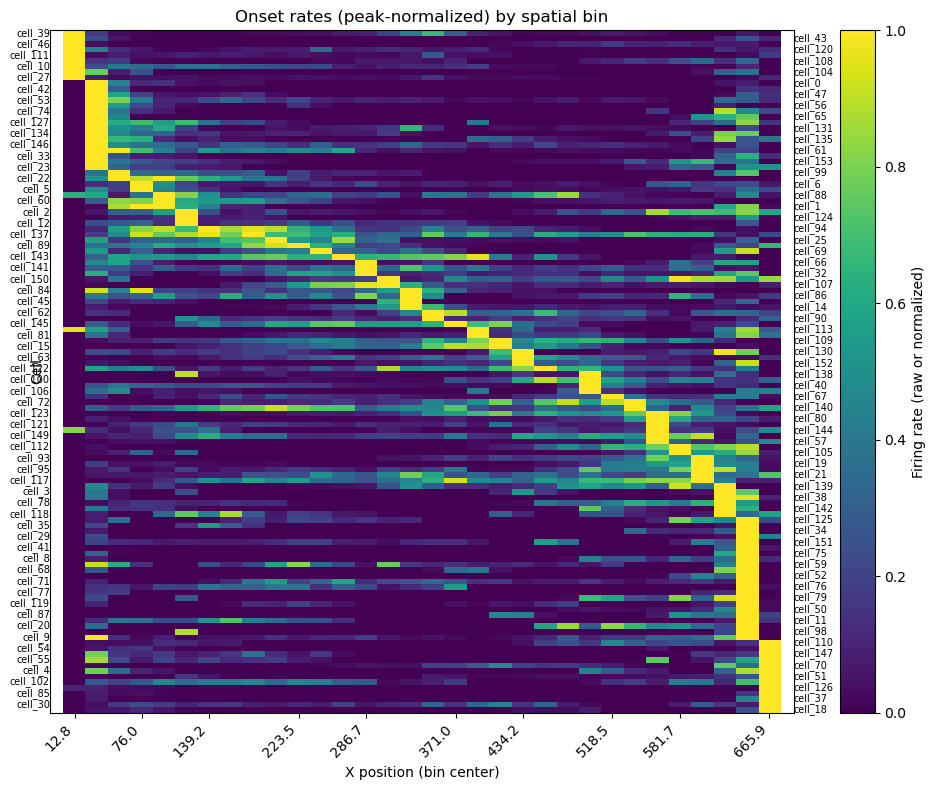

In [68]:
plot_spatial_rate_heatmap(
    spatial_rates_onsets_normalized,
    title="Onset rates (peak-normalized) by spatial bin",
    sort_by_peak_bin=True
)

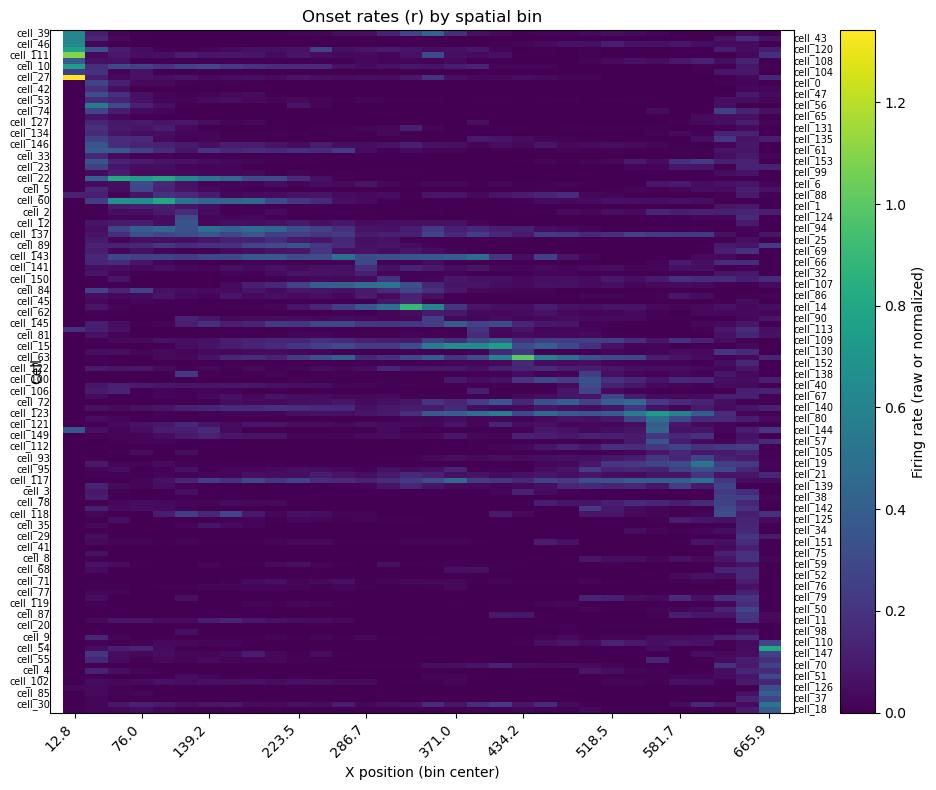

In [69]:
plot_spatial_rate_heatmap(
    spatial_rates_onsets,
    title="Onset rates (raw) by spatial bin",
    sort_by_peak_bin=True
)

In [65]:
instantaneousEventRateOnsets.head()

,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_8,cell_9,cell_10,...,cell_146,cell_147,cell_149,cell_150,cell_151,cell_152,cell_153,linearSpeedcmPerSecond,velocity2dSpatialFiltered,X_coor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0.0,569.904989
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0.0,569.904989
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.571104,0.0,569.416479
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.944788,0.0,568.666969
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.065051,0.0,568.679329


In [70]:
cell_name = "cell_0"

stats_df = compute_peak_stats_from_cell(
    signalPeaks[cell_name],                 # binarized 0/1
    z_scores=aligned_cell_traces[cell_name],# z trace used for baseline detection
    cell_trace=aligned_cell_traces[cell_name],  # same trace for amplitude/baselineVal
    tol=0.25,
    window_len_onset=3,
    window_len_offset=3,
    plt_region=10,
)

stats_df

,peak_idx,onset_idx,offset_idx,amp_max,length_samples,clip_start,clip_end,clipped_region
0,567,537,764,5.981388,227,527,774,"[1.1263907, 0.769988, 0.20960733, 0.66889536, ..."
1,605,537,764,5.981388,227,527,774,"[1.1263907, 0.769988, 0.20960733, 0.66889536, ..."
2,608,537,764,5.981388,227,527,774,"[1.1263907, 0.769988, 0.20960733, 0.66889536, ..."
3,610,537,764,5.981388,227,527,774,"[1.1263907, 0.769988, 0.20960733, 0.66889536, ..."
4,625,537,764,5.981388,227,527,774,"[1.1263907, 0.769988, 0.20960733, 0.66889536, ..."
...,...,...,...,...,...,...,...,...
63,13256,13239,13417,5.115888,178,13229,13427,"[0.10488441, 0.40218216, 0.39020473, -0.030392..."
64,13269,13239,13417,5.115888,178,13229,13427,"[0.10488441, 0.40218216, 0.39020473, -0.030392..."
65,14466,14418,14565,2.806992,147,14408,14575,"[0.4038573, 0.36273342, -0.012734259, 0.170891..."
66,15960,15930,16453,5.046996,523,15920,16463,"[-0.3184369, -0.056149274, 0.0017450713, 0.035..."


In [72]:
stats_all = compute_peak_stats_for_all_cells(
    signalPeaks,
    aligned_cell_traces,
    tol=0.25,
    window_len_onset=3,
    window_len_offset=3,
    plt_region=10,
    use_onsets=False,   # True if you want rising-edge events only
)

stats_all.head()

,cell,event_id,peak_idx,onset_idx,offset_idx,amp_max,length_samples,clip_start,clip_end,clipped_region
0,cell_0,0,567,537,764,5.981388,227,527,774,"[1.1263907, 0.769988, 0.20960733, 0.66889536, ..."
1,cell_0,1,605,537,764,5.981388,227,527,774,"[1.1263907, 0.769988, 0.20960733, 0.66889536, ..."
2,cell_0,2,608,537,764,5.981388,227,527,774,"[1.1263907, 0.769988, 0.20960733, 0.66889536, ..."
3,cell_0,3,610,537,764,5.981388,227,527,774,"[1.1263907, 0.769988, 0.20960733, 0.66889536, ..."
4,cell_0,4,625,537,764,5.981388,227,527,774,"[1.1263907, 0.769988, 0.20960733, 0.66889536, ..."


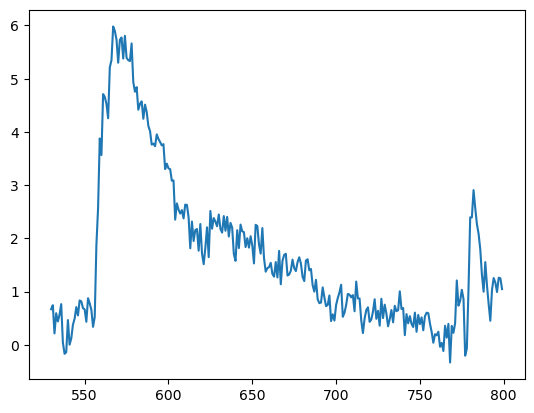

In [12]:
alignedTraces["cell_0"]
plt.plot(alignedTraces["cell_0"][530:800])

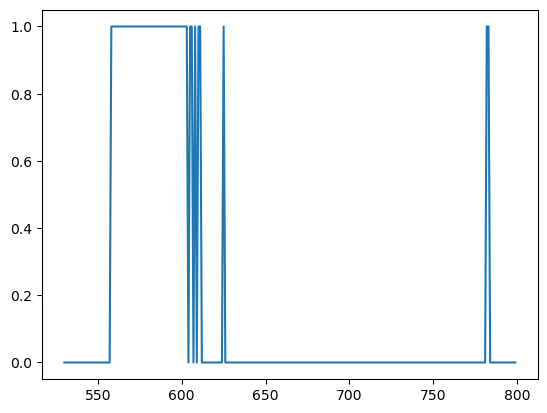

In [18]:
signalPeaks["cell_0"]
plt.plot(signalPeaks["cell_0"][530:800])

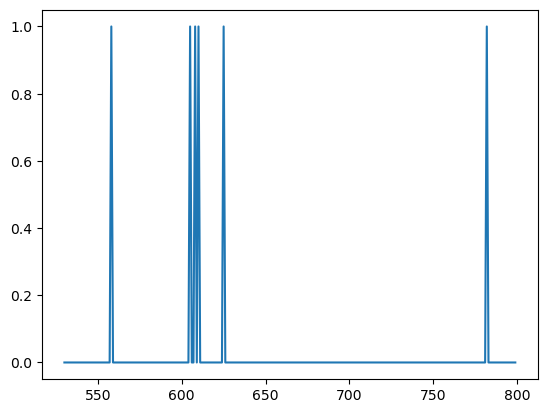

In [20]:
signalPeaks["cell_0"]
plt.plot(signalPeaksOnsets["cell_0"][530:800])

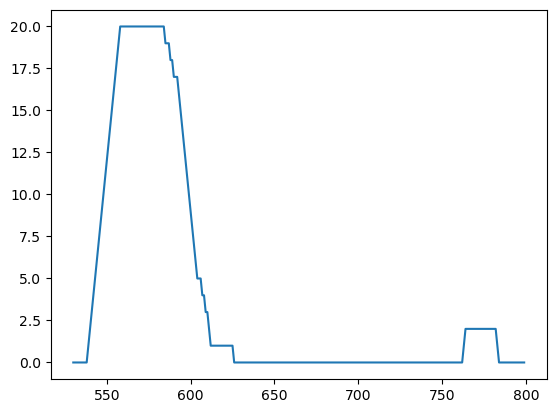

In [19]:
instantaneousEventRate["cell_0"]
plt.plot(instantaneousEventRate["cell_0"][530:800])

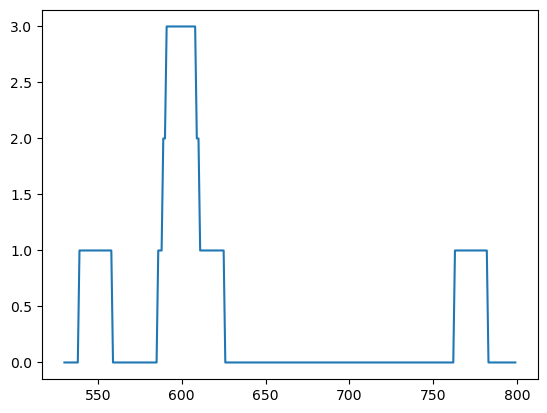

In [21]:
instantaneousEventRate["cell_0"]
plt.plot(instantaneousEventRateOnsets["cell_0"][530:800])

In [ ]:
plt.plot(instantaneousEventRate["cell_0"])

In [8]:
avg_rates.mean(axis=1)

low   high
0.0   0.5     0.486923
0.5   5.0     0.379875
5.0   10.0    0.380028
10.0  15.0    0.438999
15.0  inf     0.631562
dtype: float64

In [9]:
avg_rates_onsets.mean(axis=1)

low   high
0.0   0.5     0.108768
0.5   5.0     0.071513
5.0   10.0    0.104247
10.0  15.0    0.155350
15.0  inf     0.424443
dtype: float64

In [ ]:
alignedTraces.head()

In [75]:
## adjusts sampling of aligned traces dataframe to match behavior video 
# 1) compute the per-frame average of every numeric column
binned = (
    alignedTraces
      .groupby('closestBehavCamFrameIdx')           # group by frame-idx
      .mean(numeric_only=True)                     # mean of only number-dtype cols
)

In [79]:
stats_all_with_bins = append_binned_event_frames(stats_all, alignedTraces)
# join to binned (e.g. x position at onset bin)
stats_all_with_bins["onset_x_binned"] = binned.loc[
    stats_all_with_bins["onset_behavFrame"], "X_coor"
].to_numpy()

In [82]:
binned.head()

,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_8,cell_9,cell_10,...,Frame Number,Time Stamp (ms),Buffer Index,X_coor,Y_coor,Distance_px,velocity_PixelsPerSec,velocitySpatialFiltered,velocitySmooth,velocity2dSpatialFiltered
closestBehavCamFrameIdx,,,,,,,,,,,,,,,,,,,,,
0,1.069868,-1.324795,-1.708759,-0.790943,-0.927189,1.220309,-0.395572,-0.873842,-0.184037,0.669692,...,0.5,-11.0,0.0,569.904989,44.803742,0.000000,0.000000,0.0,0.0,0.0
1,0.888163,-0.898326,-1.737656,-0.434891,-0.713018,1.533547,-1.115240,-1.033003,-0.102110,0.635360,...,2.0,64.0,0.0,569.416479,44.591808,0.532501,10.650029,0.0,0.0,0.0
2,1.218562,-1.269087,-1.762315,-0.917298,-0.752251,1.525779,-1.183652,-1.252902,-0.875487,0.951058,...,3.0,113.0,0.0,568.666969,44.882086,0.803758,16.075151,0.0,0.0,0.0
3,1.255164,-1.501251,-1.581431,-0.949416,-1.038809,2.025037,-1.001365,-0.965129,-0.481256,0.725928,...,4.0,164.0,0.0,568.679329,45.052247,0.170610,3.412197,0.0,0.0,0.0
4,0.893578,-1.114105,-1.521060,-1.110292,-0.208177,1.788533,-0.298794,-1.050547,-0.194677,0.594408,...,5.0,215.0,0.0,568.458461,45.074967,0.222033,4.440670,0.0,0.0,0.0


In [ ]:
binned.to_csv(dirPath+'/'+sessionBase+'_velocityBehavIdx.csv')

In [88]:
## code for generating validation videos 
def _pick_fourcc_for_path(path):
    ext = os.path.splitext(path)[1].lower()
    # safest combos on most OpenCV+FFMPEG builds:
    if ext in [".mp4", ".m4v", ".mov"]:
        return cv2.VideoWriter_fourcc(*"mp4v")
    if ext == ".avi":
        return cv2.VideoWriter_fourcc(*"MJPG")
    # fallback
    return cv2.VideoWriter_fourcc(*"mp4v")

def _force_even(x):
    return int(x + (x % 2))

def _reindex_to_frames(series_or_arr, n_frames, fill="ffill"):
    s = pd.Series(series_or_arr)
    s = s.reindex(range(n_frames))
    if fill == "ffill":
        s = s.ffill().bfill()
    elif fill == "zero":
        s = s.fillna(0)
    else:
        s = s.ffill().bfill()
    return s.to_numpy()

def _make_trace_background(traces_dict, w, trace_h_per=120, pad=8):
    """
    Draws static polylines for each trace once. Returns:
      bg_bgr: (H x w x 3) image
      mapping: dict trace_name -> mapping info for y conversion
      xs_pix: x pixel for each frame (len n_frames)
    """
    names = list(traces_dict.keys())
    n_tr = len(names)
    H = trace_h_per * n_tr
    bg = np.zeros((H, w), dtype=np.uint8)

    n_frames = len(next(iter(traces_dict.values())))
    xs_pix = np.linspace(0, w - 1, n_frames).astype(np.int32)

    mapping = {}
    for i, name in enumerate(names):
        y_top = i * trace_h_per
        y_bot = y_top + trace_h_per - 1

        # separator
        if i > 0:
            cv2.line(bg, (0, y_top), (w - 1, y_top), 80, 1)

        tr = traces_dict[name].astype(float)
        vmin = np.nanpercentile(tr, 1)
        vmax = np.nanpercentile(tr, 99)
        if not np.isfinite(vmin): vmin = np.nanmin(tr)
        if not np.isfinite(vmax): vmax = np.nanmax(tr)
        if not np.isfinite(vmin): vmin = 0.0
        if not np.isfinite(vmax): vmax = 1.0
        if vmax == vmin:
            vmax = vmin + 1e-6

        y0 = y_top + pad
        y1 = y_bot - pad
        y_span = max(1, y1 - y0)

        yn = (tr - vmin) / (vmax - vmin)
        yn = np.clip(yn, 0, 1)
        ys = (y1 - (yn * y_span)).astype(np.int32)

        pts = np.stack([xs_pix, ys], axis=1).reshape(-1, 1, 2)
        cv2.polylines(bg, [pts], False, 255, 1)

        cv2.putText(bg, name, (10, y_top + 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, 200, 1, cv2.LINE_AA)

        mapping[name] = dict(vmin=vmin, vmax=vmax, y0=y0, y1=y1)

    return cv2.cvtColor(bg, cv2.COLOR_GRAY2BGR), mapping, xs_pix

def _make_spatial_strip(rate_vec, w, strip_h=22, colormap=cv2.COLORMAP_VIRIDIS):
    """
    rate_vec: length n_bins (ideally 0..1 if normalized)
    returns: (strip_h, w, 3) BGR image
    """
    v = np.asarray(rate_vec, dtype=float)
    n_bins = len(v)
    if n_bins == 0:
        return np.zeros((strip_h, w, 3), dtype=np.uint8)

    # normalize 0..255 for colormap
    v = np.nan_to_num(v, nan=0.0)
    vmin, vmax = float(np.min(v)), float(np.max(v))
    if vmax == vmin:
        vmax = vmin + 1e-6
    v01 = np.clip((v - vmin) / (vmax - vmin), 0, 1)
    v255 = (v01 * 255).astype(np.uint8)

    # expand bins across width
    # each column of strip corresponds to a bin index via linear mapping
    bin_idx_by_x = (np.linspace(0, n_bins - 1, w)).astype(int)
    row = v255[bin_idx_by_x]  # shape (w,)
    gray = np.tile(row[None, :], (strip_h, 1))  # (strip_h, w)

    strip = cv2.applyColorMap(gray, colormap)   # BGR
    return strip


def _make_trace_plus_spatial_background(
    trace_arrays,            # dict name -> 1D np array len n_frames
    spatial_rates_df,        # DataFrame indexed by bins, columns include cell_*
    w,
    trace_h=90,
    strip_h=22,
    pad=8,
    axis_color=80,
    label_color=220,
):
    """
    Returns:
      bg_bgr: (H, w, 3) static background with traces + spatial strips
      mapping: dict name -> info for trace y mapping + band limits + strip limits
      xs_pix: x pixel for each frame (len n_frames) for moving dot on trace (time axis)
    """
    names = list(trace_arrays.keys())
    n_tr = len(names)
    band_h = trace_h + strip_h
    H = band_h * n_tr

    bg = np.zeros((H, w, 3), dtype=np.uint8)

    n_frames = len(next(iter(trace_arrays.values())))
    xs_pix = np.linspace(0, w - 1, n_frames).astype(np.int32)

    mapping = {}
    for i, name in enumerate(names):
        band_top = i * band_h
        band_bot = band_top + band_h - 1

        # separator between bands
        if i > 0:
            cv2.line(bg, (0, band_top), (w - 1, band_top), (axis_color, axis_color, axis_color), 1)

        # --- trace region (top part of band) ---
        tr_top = band_top
        tr_bot = band_top + trace_h - 1

        tr = trace_arrays[name].astype(float)
        vmin = np.nanpercentile(tr, 1)
        vmax = np.nanpercentile(tr, 99)
        if not np.isfinite(vmin): vmin = np.nanmin(tr)
        if not np.isfinite(vmax): vmax = np.nanmax(tr)
        if not np.isfinite(vmin): vmin = 0.0
        if not np.isfinite(vmax): vmax = 1.0
        if vmax == vmin:
            vmax = vmin + 1e-6

        y0 = tr_top + pad
        y1 = tr_bot - pad
        y_span = max(1, y1 - y0)

        yn = (tr - vmin) / (vmax - vmin)
        yn = np.clip(yn, 0, 1)
        ys = (y1 - (yn * y_span)).astype(np.int32)

        pts = np.stack([xs_pix, ys], axis=1).reshape(-1, 1, 2)
        cv2.polylines(bg, [pts], False, (255, 255, 255), 1)

        # label
        cv2.putText(
            bg, name, (10, band_top + 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (label_color, label_color, label_color), 1, cv2.LINE_AA
        )

        # --- spatial strip region (bottom part of band) ---
        strip_top = tr_bot + 1
        strip_bot = band_bot

        if spatial_rates_df is not None and (name in spatial_rates_df.columns):
            rate_vec = spatial_rates_df[name].to_numpy()
            strip = _make_spatial_strip(rate_vec, w, strip_h=strip_h)
        else:
            strip = np.zeros((strip_h, w, 3), dtype=np.uint8)

        bg[strip_top:strip_top + strip_h, :, :] = strip

        mapping[name] = dict(
            band_top=band_top, band_bot=band_bot,
            tr_top=tr_top, tr_bot=tr_bot,
            strip_top=strip_top, strip_bot=strip_bot,
            vmin=vmin, vmax=vmax, y0=y0, y1=y1
        )

    return bg, mapping, xs_pix


def write_behavior_video_with_velocity_traces_and_onsets(
    input_vid,
    output_vid,
    binned,
    *,
    stats_all_with_bins=None,     # <- NEW
    onset_frame_col="onset_behavFrame",
    stats_cell_col="cell",
    vel_col="velocity2dSpatialFiltered",
    x_col="X_coor",
    trace_cols=None,              # None, "cell_0", or ["cell_0","cell_5"]
    bar_h=50,
    trace_h_per=120,
    dot_radius=5,
    cursor_line=True,
    draw_onset_lines=True,        # <- NEW
    onset_line_color=(0, 255, 255),  # <- NEW (BGR). yellow by default
    onset_line_thickness=1,       # <- NEW
):
    cap = cv2.VideoCapture(input_vid)
    if not cap.isOpened():
        raise IOError(f"Could not open video: {input_vid}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps is None or fps <= 0:
        fps = 20.0  # fallback

    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Ensure binned is indexed by frame number
    b = binned.copy()
    b.index = b.index.astype(int)

    # Build per-frame arrays aligned to 0..n_frames-1
    vel = _reindex_to_frames(b[vel_col] if vel_col in b.columns else [], n_frames, fill="ffill")
    xpos = _reindex_to_frames(b[x_col] if x_col in b.columns else [], n_frames, fill="ffill")

    # Optional trace panel
    plot_h = 0
    trace_bg = None
    trace_map = None
    trace_names = []
    trace_arrays = None
    xs_pix = None  # len == n_frames mapping frame_idx -> x pixel

    if trace_cols is not None:
        if isinstance(trace_cols, str):
            trace_cols = [trace_cols]
        trace_names = [c for c in trace_cols if c in b.columns]
        if len(trace_names) == 0:
            raise ValueError("None of the requested trace_cols exist in binned.")

        # precompute traces aligned to frames
        trace_arrays = {name: _reindex_to_frames(b[name], n_frames, fill="ffill") for name in trace_names}

        # build static trace background (polylines + labels)
        trace_bg, trace_map, xs_pix = _make_trace_background(trace_arrays, w, trace_h_per=trace_h_per)
        plot_h = trace_bg.shape[0]

        # --- NEW: draw onset lines once on the background (fast) ---
        if draw_onset_lines and (stats_all_with_bins is not None):
            # ensure required cols exist
            if (stats_cell_col not in stats_all_with_bins.columns) or (onset_frame_col not in stats_all_with_bins.columns):
                raise ValueError(
                    f"stats_all_with_bins must contain columns '{stats_cell_col}' and '{onset_frame_col}'."
                )

            # cache x pixel lookup for frame index
            # if xs_pix came from np.linspace it is already per-frame x pixel
            # but onset frames might be out-of-range; we'll clip
            for name in trace_names:
                # select this cell's onset behavior frames
                onset_frames = stats_all_with_bins.loc[
                    stats_all_with_bins[stats_cell_col] == name, onset_frame_col
                ].dropna().astype(int).to_numpy()

                if onset_frames.size == 0:
                    continue

                onset_frames = onset_frames[(onset_frames >= 0) & (onset_frames < n_frames)]
                if onset_frames.size == 0:
                    continue

                # y-range for this trace panel strip
                # (each trace is in its own band of height trace_h_per)
                # This matches _make_trace_background layout.
                # band i is [i*trace_h_per, (i+1)*trace_h_per - 1]
                i = trace_names.index(name)
                y0 = i * trace_h_per
                y1 = (i + 1) * trace_h_per - 1

                # draw vertical lines at each onset
                for fidx in onset_frames:
                    xline = int(xs_pix[fidx])
                    cv2.line(trace_bg, (xline, y0), (xline, y1), onset_line_color, onset_line_thickness)

    # Make output dimensions encoder-friendly (even)
    w_out = _force_even(w)
    out_h = _force_even(h + bar_h + plot_h)

    need_resize_w = (w_out != w)

    fourcc = _pick_fourcc_for_path(output_vid)
    out = cv2.VideoWriter(output_vid, fourcc, fps, (w_out, out_h))
    if not out.isOpened():
        raise IOError(
            "VideoWriter failed to open. Try:\n"
            "  • output_vid ending with .avi (XVID) OR .mp4 (mp4v)\n"
            "  • ensure OpenCV/FFMPEG supports the codec\n"
            f"Got output_vid={output_vid}"
        )

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2
    margin = 10

    for frame_idx in tqdm(range(n_frames), desc="Adding overlay"):
        ret, frame = cap.read()
        if not ret:
            break

        if need_resize_w:
            frame = cv2.resize(frame, (w_out, h), interpolation=cv2.INTER_AREA)

        # Velocity bar
        bar = np.zeros((bar_h, w_out, 3), dtype=np.uint8)
        v = float(vel[frame_idx]) if frame_idx < len(vel) else 0.0
        vel_text = f"{v:.2f} cm/s"
        (tw, th), _ = cv2.getTextSize(vel_text, font, font_scale, thickness)
        cv2.putText(bar, vel_text, (margin, margin + th),
                    font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

        xm = int(np.clip(xpos[frame_idx], 0, w_out - 1))
        cv2.circle(bar, (xm, bar_h // 2), dot_radius, (255, 255, 255), -1)

        if trace_bg is not None:
            plot_img = trace_bg.copy()
            if need_resize_w:
                plot_img = cv2.resize(plot_img, (w_out, plot_h), interpolation=cv2.INTER_AREA)

            # moving cursor line
            xcur = int(xs_pix[frame_idx]) if xs_pix is not None else int((frame_idx / max(1, n_frames - 1)) * (w_out - 1))
            if cursor_line:
                cv2.line(plot_img, (xcur, 0), (xcur, plot_h - 1), (120, 120, 120), 1)

            # moving dot per trace
            for i, name in enumerate(trace_names):
                m = trace_map[name]
                tr = trace_arrays[name]
                val = float(tr[frame_idx])
                yn = (val - m["vmin"]) / (m["vmax"] - m["vmin"])
                yn = float(np.clip(yn, 0, 1))
                ycur = int(round(m["y1"] - yn * (m["y1"] - m["y0"])))
                cv2.circle(plot_img, (xcur, ycur), dot_radius, (255, 255, 255), -1)

            stacked = np.vstack([frame, bar, plot_img])
        else:
            stacked = np.vstack([frame, bar])

        # pad/crop to out_h if needed
        if stacked.shape[0] < out_h:
            pad_h = out_h - stacked.shape[0]
            stacked = np.vstack([stacked, np.zeros((pad_h, w_out, 3), dtype=np.uint8)])
        elif stacked.shape[0] > out_h:
            stacked = stacked[:out_h, :, :]

        out.write(stacked)

    cap.release()
    out.release()
    print("Done – saved with overlay to:", output_vid)

from tqdm import tqdm

def write_behavior_video_with_velocity_traces_onsets_and_spatialrow(
    input_vid,
    output_vid,
    binned,
    spatial_rates_df,
    *,
    stats_all_with_bins=None,
    onset_frame_col="onset_behavFrame",
    stats_cell_col="cell",
    vel_col="velocity2dSpatialFiltered",
    x_col="X_coor",
    trace_cols=None,
    bar_h=50,
    trace_h=90,
    strip_h=22,
    dot_radius=5,
    cursor_line=True,              # time cursor on trace
    draw_onset_lines=True,
    onset_line_color=(0, 255, 255),
    onset_line_thickness=1,
    xpos_marker_color=(255, 255, 255),   # marker on spatial strip (current X)
    prefer_fiji=True,              # write MJPG AVI for FIJI
):
    cap = cv2.VideoCapture(input_vid)
    if not cap.isOpened():
        raise IOError(f"Could not open video: {input_vid}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps is None or fps <= 0:
        fps = 20.0

    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # --- align binned to frames 0..n_frames-1 ---
    b = binned.copy()
    b.index = b.index.astype(int)

    def _reindex_to_frames(series, n, fill="ffill"):
        s = pd.Series(series)
        s = s.reindex(range(n))
        if fill == "ffill":
            s = s.ffill().bfill()
        else:
            s = s.fillna(0)
        return s.to_numpy()

    vel = _reindex_to_frames(b[vel_col] if vel_col in b.columns else [], n_frames, fill="ffill")
    xpos = _reindex_to_frames(b[x_col] if x_col in b.columns else [], n_frames, fill="ffill")

    # --- choose traces to show ---
    plot_h = 0
    trace_bg = None
    trace_map = None
    trace_names = []
    trace_arrays = None
    xs_pix = None

    if trace_cols is not None:
        if isinstance(trace_cols, str):
            trace_cols = [trace_cols]
        trace_names = [c for c in trace_cols if c in b.columns]
        if len(trace_names) == 0:
            raise ValueError("None of the requested trace_cols exist in binned.")

        trace_arrays = {name: _reindex_to_frames(b[name], n_frames, fill="ffill") for name in trace_names}

        trace_bg, trace_map, xs_pix = _make_trace_plus_spatial_background(
            trace_arrays,
            spatial_rates_df=spatial_rates_df,
            w=w,
            trace_h=trace_h,
            strip_h=strip_h
        )
        plot_h = trace_bg.shape[0]

        # Draw onset lines once (fast)
        if draw_onset_lines and (stats_all_with_bins is not None):
            for name in trace_names:
                onset_frames = stats_all_with_bins.loc[
                    stats_all_with_bins[stats_cell_col] == name, onset_frame_col
                ].dropna().astype(int).to_numpy()

                onset_frames = onset_frames[(onset_frames >= 0) & (onset_frames < n_frames)]
                if onset_frames.size == 0:
                    continue

                y0 = trace_map[name]["band_top"]
                y1 = trace_map[name]["band_bot"]
                for fidx in onset_frames:
                    xline = int(xs_pix[fidx])
                    cv2.line(trace_bg, (xline, y0), (xline, y1), onset_line_color, onset_line_thickness)

    # --- output dimensions (even) ---
    def _force_even(x): return int(x + (x % 2))
    w_out = _force_even(w)
    out_h = _force_even(h + bar_h + plot_h)
    need_resize_w = (w_out != w)

    # --- codec: MJPG AVI is most FIJI-friendly ---
    if prefer_fiji:
        # strongly recommend .avi for MJPG
        if not output_vid.lower().endswith(".avi"):
            output_vid = os.path.splitext(output_vid)[0] + ".avi"
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    else:
        # mp4v if you insist on mp4
        fourcc = cv2.VideoWriter_fourcc(*("mp4v" if output_vid.lower().endswith(".mp4") else "MJPG"))

    out = cv2.VideoWriter(output_vid, fourcc, fps, (w_out, out_h))
    if not out.isOpened():
        raise IOError(f"VideoWriter failed to open for {output_vid}. Try output .avi + MJPG.")

    # --- compute spatial bin edges for mapping current X position to a strip x pixel ---
    # Use x_left/x_right if present; otherwise use min/max over binned X and n_bins
    if ("x_left" in spatial_rates_df.columns) and ("x_right" in spatial_rates_df.columns):
        edges = np.r_[spatial_rates_df["x_left"].to_numpy(), spatial_rates_df["x_right"].to_numpy()[-1]]
    else:
        n_bins = len(spatial_rates_df.index)
        xmin = np.nanmin(b[x_col].to_numpy())
        xmax = np.nanmax(b[x_col].to_numpy())
        edges = np.linspace(xmin, xmax, n_bins + 1)

    n_bins = len(edges) - 1

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2
    margin = 10

    for frame_idx in tqdm(range(n_frames), desc="Adding overlay"):
        ret, frame = cap.read()
        if not ret:
            break

        if need_resize_w:
            frame = cv2.resize(frame, (w_out, h), interpolation=cv2.INTER_AREA)

        # velocity bar
        bar = np.zeros((bar_h, w_out, 3), dtype=np.uint8)
        v = float(vel[frame_idx]) if frame_idx < len(vel) else 0.0
        vel_text = f"{v:.2f} cm/s"
        (tw, th), _ = cv2.getTextSize(vel_text, font, font_scale, thickness)
        cv2.putText(bar, vel_text, (margin, margin + th),
                    font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

        xm = int(np.clip(xpos[frame_idx], 0, w_out - 1))
        cv2.circle(bar, (xm, bar_h // 2), dot_radius, (255, 255, 255), -1)

        # trace+spatial panel
        if trace_bg is not None:
            plot_img = trace_bg.copy()
            if need_resize_w:
                plot_img = cv2.resize(plot_img, (w_out, plot_h), interpolation=cv2.INTER_AREA)

            # time cursor on traces
            xcur_time = int(xs_pix[frame_idx]) if xs_pix is not None else int((frame_idx / max(1, n_frames - 1)) * (w_out - 1))
            if cursor_line:
                cv2.line(plot_img, (xcur_time, 0), (xcur_time, plot_h - 1), (120, 120, 120), 1)

            # current X position -> bin -> pixel on spatial strip
            x_now = float(xpos[frame_idx])
            bin_idx = int(np.clip(np.digitize(x_now, edges) - 1, 0, n_bins - 1))
            xcur_space = int(round((bin_idx + 0.5) / n_bins * (w_out - 1)))

            for name in trace_names:
                m = trace_map[name]
                tr = trace_arrays[name]
                val = float(tr[frame_idx])

                # moving dot on trace (time axis)
                yn = (val - m["vmin"]) / (m["vmax"] - m["vmin"])
                yn = float(np.clip(yn, 0, 1))
                ycur = int(round(m["y1"] - yn * (m["y1"] - m["y0"])))
                cv2.circle(plot_img, (xcur_time, ycur), dot_radius, (255, 255, 255), -1)

                # moving marker on spatial strip (space axis)
                y0 = m["strip_top"]
                y1 = m["strip_bot"]
                cv2.line(plot_img, (xcur_space, y0), (xcur_space, y1), xpos_marker_color, 1)

            stacked = np.vstack([frame, bar, plot_img])
        else:
            stacked = np.vstack([frame, bar])

        # pad/crop to out_h if needed
        if stacked.shape[0] < out_h:
            pad_h = out_h - stacked.shape[0]
            stacked = np.vstack([stacked, np.zeros((pad_h, w_out, 3), dtype=np.uint8)])
        elif stacked.shape[0] > out_h:
            stacked = stacked[:out_h, :, :]

        out.write(stacked)

    cap.release()
    out.release()
    print("Done – saved with overlay to:", output_vid)


In [90]:
dirPath      = '/Users/johnmarshall/Documents/Analysis/miniscope_analysis/miniscopeLinearTrack/firingRateAnalysis/07_2025_m388/'
rotatedVideo = '388_run4_20250702_behavCamFiles_concactenatedbehavCam00_behavCam20.mp4'

input_vid  = os.path.join(dirPath, rotatedVideo)
# Recommend: use .avi if you want FIJI-friendly XVID
output_vid = os.path.join(
    dirPath,
    rotatedVideo.replace(".mp4", "_with_vel_and_traces.avi")
)

write_behavior_video_with_velocity_traces_onsets_and_spatialrow(
    input_vid=os.path.join(dirPath, rotatedVideo),
    output_vid=output_vid,
    binned=binned,
    spatial_rates_df=spatial_rates_onsets_normalized,   # <- heatmap rows come from here
    stats_all_with_bins=stats_all_with_bins,            # <- onset lines
    trace_cols=["cell_27", "cell_63"],
    prefer_fiji=True,                                   # writes MJPG .avi for FIJI
)

Adding overlay: 100%|█████████████████████████████████████████████████████████████████████████████| 20566/20566 [01:22<00:00, 248.29it/s]

Done – saved with overlay to: /Users/johnmarshall/Documents/Analysis/miniscope_analysis/miniscopeLinearTrack/firingRateAnalysis/07_2025_m388/388_run4_20250702_behavCamFiles_concactenatedbehavCam00_behavCam20_with_vel_and_traces.avi


In [63]:
##validate with video overlay  
#small video 

# ── CONFIG ─────────────────────────────────────────────────────────────────────

dirPath      = '/Users/johnmarshall/Documents/Analysis/miniscope_analysis/miniscopeLinearTrack/firingRateAnalysis/07_2025_m388/'
rotatedVideo = '388_run4_20250702_behavCamFiles_concactenatedbehavCam00_behavCam20.mp4'
input_vid    = os.path.join(dirPath, rotatedVideo)
output_vid   = os.path.join(dirPath, rotatedVideo.strip('.mp4')+'_with_velocity_overlay_.mp4')

# your velocity array (length == # frames)
vel_array = binned['velocity2dSpatialFiltered'].to_numpy()

# your per-behavior-frame X positions (make sure it's indexed by frame 0…n-1)
# e.g. binned = binned.reset_index().set_index('frame')
x_pos = binned['X_coor'].to_numpy()

# height of the black bar you want to add
bar_h = 50

# ── SET UP I/O ─────────────────────────────────────────────────────────────────

cap      = cv2.VideoCapture(input_vid)
fps      = cap.get(cv2.CAP_PROP_FPS)
w        = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h        = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# choose a codec that FIJI likes for AVIs
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out    = cv2.VideoWriter(output_vid, fourcc, fps, (w, h + bar_h))

# text & dot styling
font        = cv2.FONT_HERSHEY_SIMPLEX
font_scale  = 1
thickness   = 2
margin      = 10
dot_radius  = 5

# ── PROCESS FRAMES ──────────────────────────────────────────────────────────────

for frame_idx in tqdm(range(n_frames-1), desc="Adding overlay"):
    ret, frame = cap.read()
    if not ret:
        break

    # 1) create the padded frame
    bar       = np.zeros((bar_h, w, 3), dtype=np.uint8)
    new_frame = np.vstack((frame, bar))

    # 2) overlay the velocity text in the bar (left‐aligned)
    vel_text = f"{vel_array[frame_idx-1]:.2f} cm/s"
    (tw, th), _ = cv2.getTextSize(vel_text, font, font_scale, thickness)
    text_x = margin
    text_y = h + margin + th
    cv2.putText(
        new_frame,
        vel_text,
        (text_x, text_y),
        font,
        font_scale,
        (255, 255, 255),
        thickness,
        cv2.LINE_AA
    )

    # 3) draw the dot at the mouse’s X in the center of the bar
    xm = int(np.clip(x_pos[frame_idx-1], 0, w-1))
    y_dot = h + bar_h // 2
    cv2.circle(new_frame, (xm, y_dot), dot_radius, (255, 255, 255), -1)

    out.write(new_frame)

# ── CLEAN UP ────────────────────────────────────────────────────────────────────

cap.release()
out.release()
print("Done – saved with overlay to:", output_vid)

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
Adding overlay: 100%|█████████████████████████████████████████████████████████████████████████████| 20565/20565 [00:37<00:00, 551.23it/s]

Done – saved with overlay to: /Users/johnmarshall/Documents/Analysis/miniscope_analysis/miniscopeLinearTrack/firingRateAnalysis/07_2025_m388/388_run4_20250702_behavCamFiles_concactenatedbehavCam00_behavCam20_with_velocity_overlay_.mp4


In [ ]:
path = "/Volumes/fsmresfiles/Basic_Sciences/Phys/ContractorLab/Projects/Common Files/JJM_YZ_CaImaging/2025.7/388_20250702_video_output_20min.avi"

cap = cv2.VideoCapture(path)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {path}")

count = 0
for _ in tqdm(iter(int, 1), desc="Counting frames"):  # infinite loop
    ret, _frame = cap.read()
    if not ret:
        break
    count += 1

fps = cap.get(cv2.CAP_PROP_FPS)
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

print("counted frames:", count, "fps:", fps, "size:", (w, h))

In [ ]:
len(vel_array)

In [ ]:
binned.index

In [ ]:
binned.loc[20563]

In [ ]:
vel_array[20562]

In [ ]:
n_frames